In [1]:
import kagglehub
path = kagglehub.dataset_download("denkuznetz/traffic-accident-prediction")
print("Path to dataset files:", path)

Path to dataset files: /home/omnia/.cache/kagglehub/datasets/denkuznetz/traffic-accident-prediction/versions/1


In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules for model building, preprocessing, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
# Import SMOTE from imblearn to address class imbalance
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
# Set a modern theme for plots
sns.set_theme(style='whitegrid', palette='deep', font_scale=1.2)

In [3]:
# Load the dataset
#  'traffic_accident_prediction.csv' is in  working directory
df = pd.read_csv('traffic_accident_prediction.csv')

# Display the first 5 rows of the dataset to get an overview
print("First 5 rows of the dataset:")
print(df.head())

# Print dataset information to check data types and non-null counts
print("\nDataset Information:")
print(df.info())

# Display descriptive statistics for numerical features
print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values in each column
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

First 5 rows of the dataset:
  Weather   Road_Type Time_of_Day  Traffic_Density  Speed_Limit  \
0   Rainy   City Road     Morning              1.0        100.0   
1   Clear  Rural Road       Night              NaN        120.0   
2   Rainy     Highway     Evening              1.0         60.0   
3   Clear   City Road   Afternoon              2.0         60.0   
4   Rainy     Highway     Morning              1.0        195.0   

   Number_of_Vehicles  Driver_Alcohol Accident_Severity      Road_Condition  \
0                 5.0             0.0               NaN                 Wet   
1                 3.0             0.0          Moderate                 Wet   
2                 4.0             0.0               Low                 Icy   
3                 3.0             0.0               Low  Under Construction   
4                11.0             0.0               Low                 Dry   

  Vehicle_Type  Driver_Age  Driver_Experience Road_Light_Condition  Accident  
0          Car

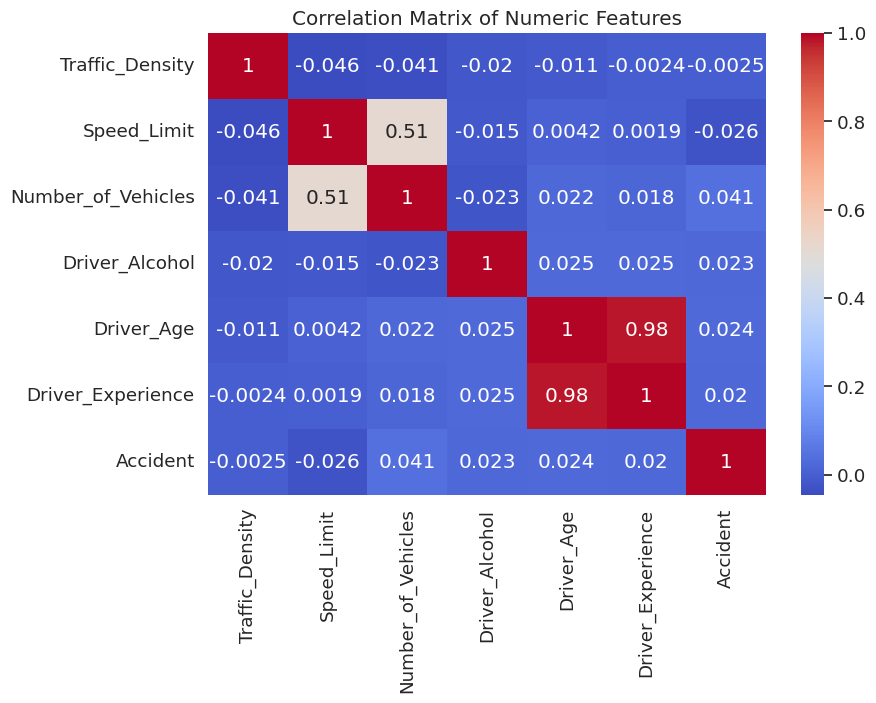

In [4]:
#  Data Visualization

# Select only numeric columns from the DataFrame
numeric_df = df.select_dtypes(include=[np.number])

# Create a heatmap to visualize the correlation matrix of numeric features
plt.figure(figsize=(9,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()



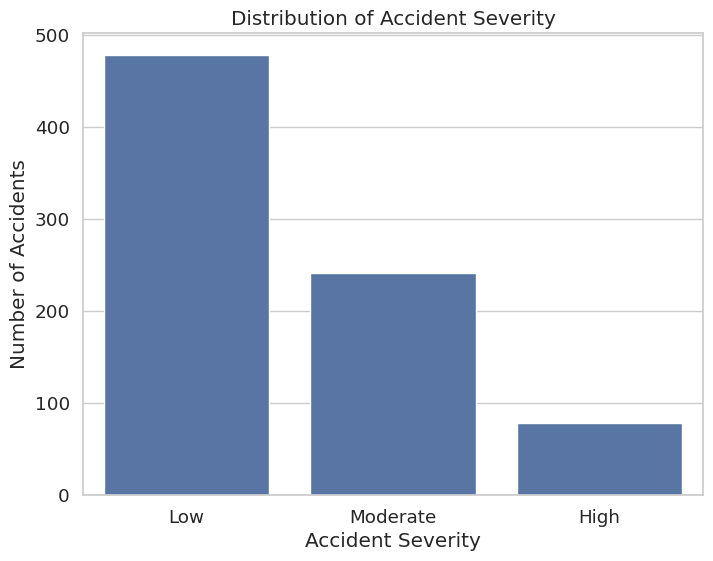

In [5]:
#  Data Visualization


# Plot the distribution of the target variable "Accident_Severity"
plt.figure(figsize=(8, 6))
sns.countplot(x='Accident_Severity', data=df, order=['Low', 'Moderate', 'High'])
plt.title('Distribution of Accident Severity')
plt.xlabel('Accident Severity')
plt.ylabel('Number of Accidents')
plt.show()



/tmp/ipykernel_238409/899814740.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Road_Light_Condition', data=df, palette=custom_colors)


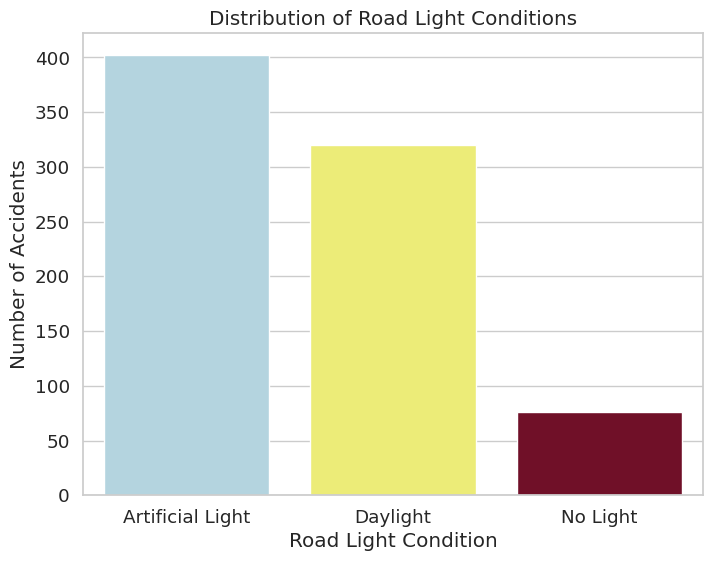

In [6]:

custom_colors = ['#ADD8E6', '#FFFF65', '#800020']

plt.figure(figsize=(8, 6))
sns.countplot(x='Road_Light_Condition', data=df, palette=custom_colors)
plt.title('Distribution of Road Light Conditions')
plt.xlabel('Road Light Condition')
plt.ylabel('Number of Accidents')
plt.show()


In [7]:
from scipy.stats import chi2_contingency
# not only light condition
contingency_table = pd.crosstab(df['Road_Light_Condition'], df['Accident'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("p-value =", p_value)
# high value --> not related 

p-value = 0.9761393373712018


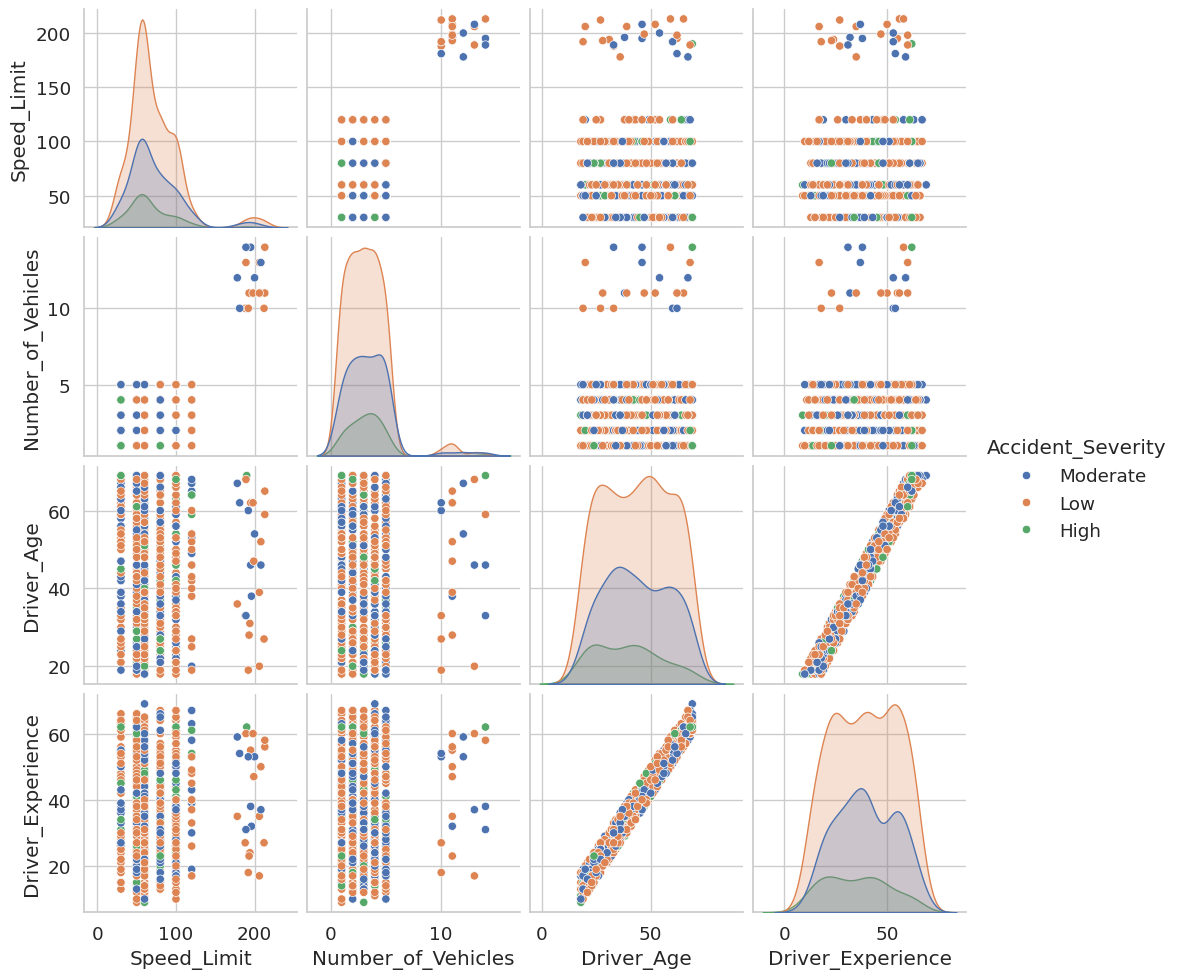

In [8]:

# Create a pairplot for selected numerical features along with the target variable
selected_features = ['Speed_Limit', 'Number_of_Vehicles', 'Driver_Age', 'Driver_Experience']
sns.pairplot(df[selected_features + ['Accident_Severity']], hue='Accident_Severity')
plt.show()





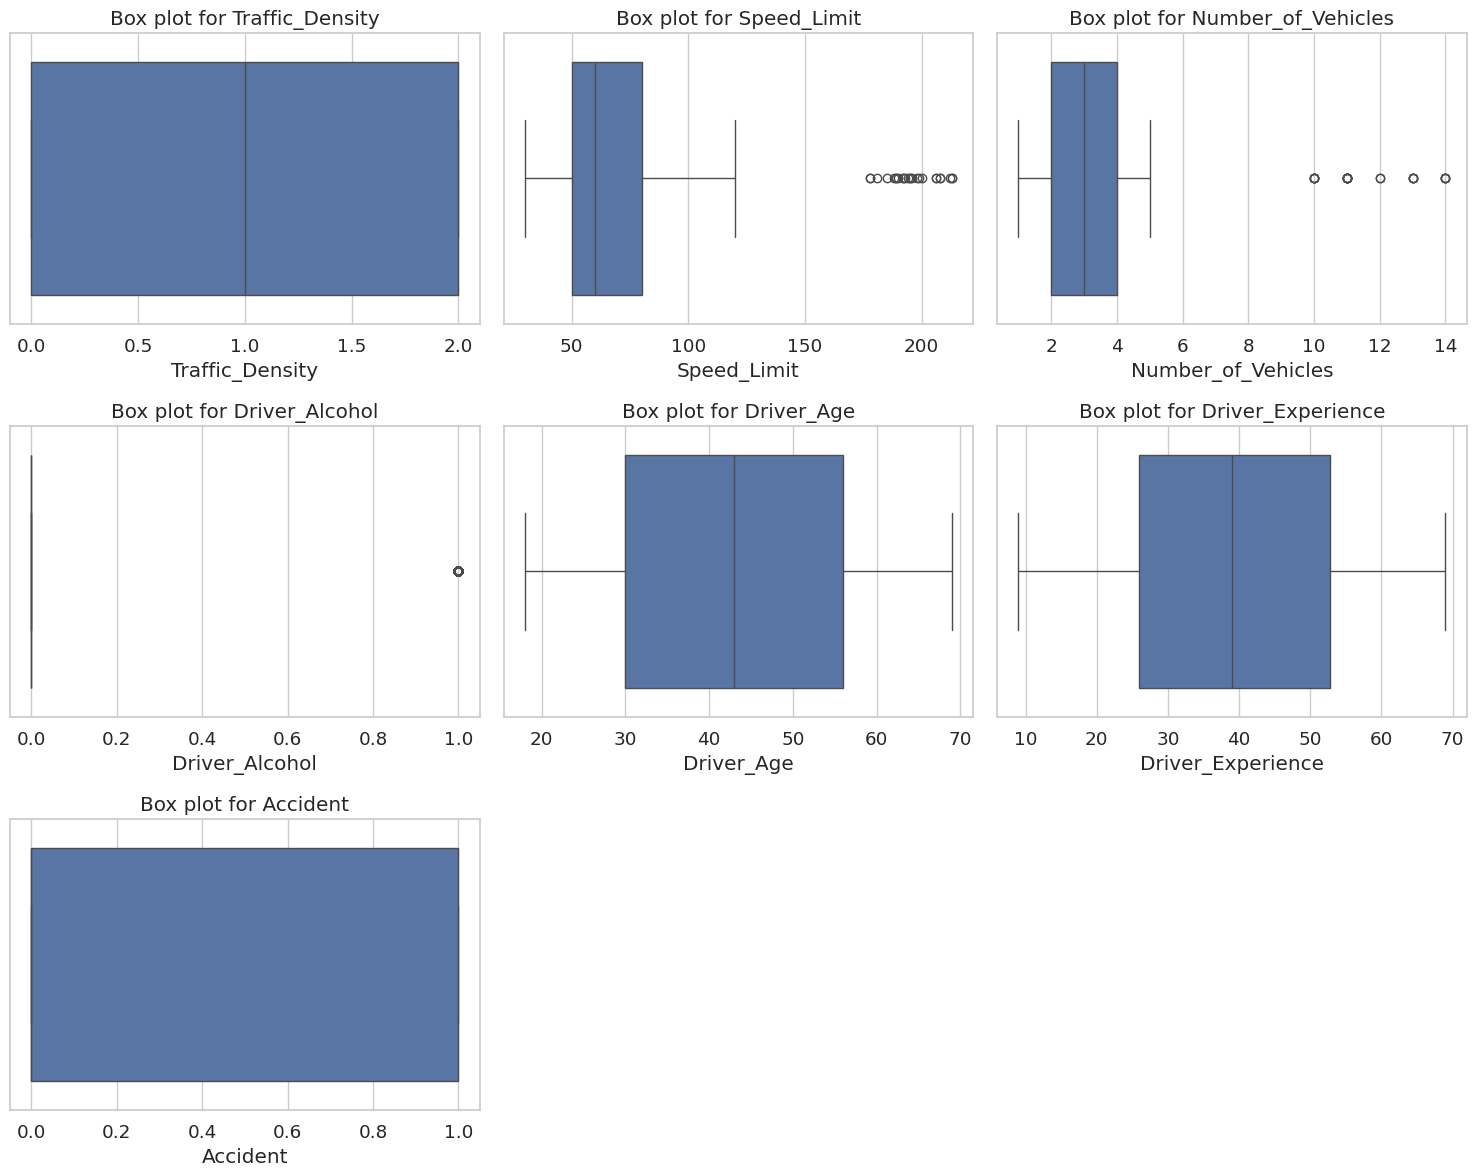

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# double check ouliers
# Step: Visualize outliers using Box Plot for each numeric column
# Create a box plot for each numeric column in the DataFrame
plt.figure(figsize=(15, 12))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
# Loop through each numeric column and plot the box plot
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  #  rowsو columns for the subplots (adjust as needed)
    sns.boxplot(data=df, x=col)
    plt.title(f'Box plot for {col}')

plt.tight_layout()  # Adjust the layout to avoid overlap
plt.show()


In [12]:
# Data Preprocessing


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# Step 0: Separate features and target
X = df.drop('Accident', axis=1)
y = df['Accident']

# Step 1: Split the data first (to avoid data leakage!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Identify column types
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = [col for col in X.columns if col not in numeric_cols]



# # Drop those rows from both X_test and y_test
# X_test = X_test[~test_all_nan]
# y_test = y_test[~test_all_nan]

# Step 3: Impute numeric columns
num_imputer = SimpleImputer(strategy='median')
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

# Step 4: Impute categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])

# Step 5: Label encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le  # Store if needed later

# Step 6: Encode target (if not already binary)
target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(y_train)
y_test = target_encoder.transform(y_test)

# Step 7: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 8: Check processed data
print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)
print("\nSample After Preprocessing:")
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).head())

print("\nTarget Distribution (Train):")
print(pd.Series(y_train).value_counts())

# Confirm no missing values
print("\nMissing in X_train:\n", pd.DataFrame(X_train_scaled).isnull().sum())
print("\nMissing in X_test:\n", pd.DataFrame(X_test_scaled).isnull().sum())

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (672, 13)
y_train shape: (672,)

Sample After Preprocessing:
    Weather  Road_Type  Time_of_Day  Traffic_Density  Speed_Limit  \
0  0.657949  -1.132661     -0.11341        -1.289574     0.943625   
1 -0.949840  -1.132661     -1.06605         0.023447    -1.254460   
2 -0.949840  -0.091419     -1.06605        -1.289574    -0.626436   
3 -0.949840  -0.091419     -0.11341         0.023447     0.315601   
4  0.657949   1.991066     -1.06605         0.023447    -0.312423   

   Number_of_Vehicles  Driver_Alcohol  Accident_Severity  Road_Condition  \
0           -0.163109        2.363945          -0.327281        0.036728   
1           -1.137411        2.363945          -2.045507        1.738885   
2           -0.650260       -0.423022          -0.327281       -0.814350   
3            0.324042       -0.423022          -0.327281       -0.814350   
4            0.324042       -0.423022          -0.327281       -0.814350   

   Vehicle_Type  Driver_Age  Driver_Experience  Road

In [13]:
#visualization after preprocessing

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


# Also keep a copy of the original (imputed & encoded) training data
# if you want to visualize categorical distributions with readable labels
orig_train_df = X_train.copy()
orig_train_df['Accident'] = y_train

# Step 1: Correlation Matrix Heatmap on scaled numeric features
plt.figure(figsize=(14, 10))
sns.heatmap(
    train_scaled_df.drop('Accident', axis=1).corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)
plt.title('Correlation Matrix of Scaled Numeric Features')
plt.show()

# Step 2: Distribution of the target variable in the train set
plt.figure(figsize=(8, 6))
sns.countplot(
    x='Accident',
    data=train_scaled_df,
    palette='Set1'
)
plt.title('Distribution of Accident (0=No, 1=Yes) in Training Set')
plt.xlabel('Accident')
plt.ylabel('Count')
plt.show()

# Step 3: Distribution of a categorical feature (e.g. Road_Light_Condition)
# Using orig_train_df so labels are human‑readable
plt.figure(figsize=(10, 6))
sns.countplot(
    x='Road_Light_Condition',
    data=orig_train_df,
    palette='Set1',
    order=orig_train_df['Road_Light_Condition'].value_counts().index
)
plt.title('Distribution of Road Light Condition (Train Set)')
plt.xlabel('Road Light Condition')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Step 4: Pairplot for selected numerical features and the target
selected_features = ['Speed_Limit', 'Number_of_Vehicles', 'Driver_Age', 'Driver_Experience']
sns.pairplot(
    train_scaled_df[selected_features + ['Accident']],
    hue='Accident',
    palette='Set2',
    diag_kind='hist'
)
plt.suptitle('Pairplot of Selected Features vs. Accident', y=1.02)
plt.show()
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (672, 13)
y_train shape: (672,)
X_test shape: (168, 13)
y_test shape: (168,)


NameError: name 'train_scaled_df' is not defined

<Figure size 1400x1000 with 0 Axes>

In [14]:

# Accuracy with logistic regression, Random forest , Desicion tree
# Step 1: Check alignment once

assert X_train.shape[0] == len(y_train), "Mismatch in training data length"
assert X_test.shape[0] == len(y_test), "Mismatch in testing data length"

# Step 2: Compute correlation on training data only
df_train = pd.DataFrame(X_train, columns=X_train.columns)
df_train['Accident'] = y_train
train_corr = df_train.corr()

# Step 3: Select features with correlation above threshold
threshold = 0.03
high_corr_features = train_corr.index[abs(train_corr['Accident']) > threshold].tolist()
high_corr_features.remove('Accident') if 'Accident' in high_corr_features else None
selected_indices = [X_train.columns.get_loc(col) for col in high_corr_features]

# Step 4: Slice feature columns
X_train_sel = X_train.iloc[:, selected_indices]
X_test_sel = X_test.iloc[:, selected_indices]

# Step 5: Scale the selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

# Sanity check
print(f"🔹 Training Set: {len(y_train)} samples")
print(f"🔹 Test Set:     {len(y_test)} samples")
assert X_test_scaled.shape[0] == len(y_test), "Mismatch after scaling"

# Step 6: Define and train models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(random_state=45, class_weight='balanced')
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} - Test Accuracy: {accuracy:.4f}")

# Final summary
print("\nModel Performance Summary:")
for name, acc in results.items():
    print(f"- {name}: {acc:.4f}")


🔹 Training Set: 672 samples
🔹 Test Set:     168 samples
Logistic Regression - Test Accuracy: 0.6667
Decision Tree - Test Accuracy: 0.5476
Random Forest - Test Accuracy: 0.6190

Model Performance Summary:
- Logistic Regression: 0.6667
- Decision Tree: 0.5476
- Random Forest: 0.6190


In [15]:
print(X_train.shape[0], y_train.shape[0])
print("\nModel Performance Summary:")
for name, acc in results.items():
    print(f"- {name}: {acc:.4f}")

# Displaying the distribution of the 'Accident_Severity' column
print("\nAccident Severity Distribution:")
print(df['Accident_Severity'].value_counts())

# Displaying the shape of the scaled training and testing datasets
print("\nScaled Data Shapes:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Initializing the Random Forest Classifier model
model = RandomForestClassifier()

# Training the model on the scaled training data
model.fit(X_train_scaled, y_train)

# Extracting feature importances from the trained model
importances = model.feature_importances_

# Displaying the column names and their corresponding importance scores
print("\nFeature Importances:")
for col, imp in zip(X.columns[selected_indices], importances):
    print(f"{col}: {imp:.4f}")

# Displaying the distribution of the target variable in the training set
print("\nClass distribution in y_train:")
print(pd.Series(y_train).value_counts())

# Displaying the distribution of the target variable in the testing set
print("\nClass distribution in y_test:")
print(pd.Series(y_test).value_counts())

672 672

Model Performance Summary:
- Logistic Regression: 0.6667
- Decision Tree: 0.5476
- Random Forest: 0.6190

Accident Severity Distribution:
Accident_Severity
Low         478
Moderate    241
High         79
Name: count, dtype: int64

Scaled Data Shapes:
X_train_scaled shape: (672, 6)
X_test_scaled shape: (168, 6)

Feature Importances:
Time_of_Day: 0.1006
Speed_Limit: 0.1536
Accident_Severity: 0.0741
Road_Condition: 0.0767
Driver_Age: 0.2944
Driver_Experience: 0.3006

Class distribution in y_train:
0    447
1    188
2     37
Name: count, dtype: int64

Class distribution in y_test:
0    112
1     51
2      5
Name: count, dtype: int64


In [19]:
print(X_train.shape[0], y_train.shape[0])

800 800


Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.50      0.58       168
         1.0       0.30      0.50      0.38        72

    accuracy                           0.50       240
   macro avg       0.50      0.50      0.48       240
weighted avg       0.58      0.50      0.52       240



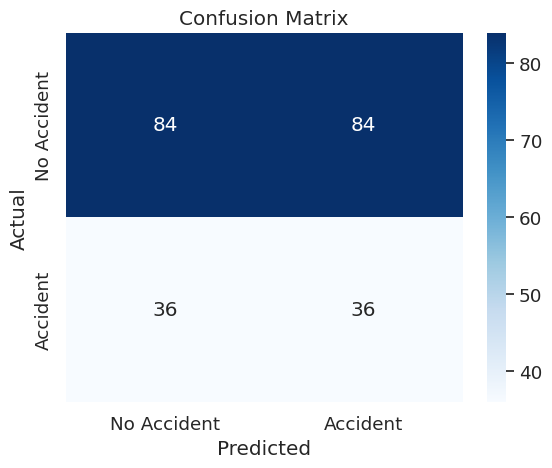

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 0) Prepare X and y
X = df[['Time_of_Day','Speed_Limit','Accident_Severity',
        'Road_Condition','Driver_Age','Driver_Experience']].copy()
y = df['Accident'].copy()

# 1) Drop any rows where the target is missing (NaN)
mask = y.notna()
X = X[mask]
y = y[mask]


# 2) Train-test split (stratify to preserve imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 3) Target encode the three categorical features on the TRAINING fold
for cat in ['Time_of_Day','Accident_Severity','Road_Condition']:
    means = (pd.DataFrame({cat: X_train[cat], 'target': y_train})
               .groupby(cat)['target']
               .mean())
    X_train[cat] = X_train[cat].map(means)
    X_test[cat]  = X_test[cat].map(means).fillna(y_train.mean())

# 4) Impute any remaining NaNs in features with the median
imp = SimpleImputer(strategy='median')
X_train_imputed = imp.fit_transform(X_train) 
X_test_imputed  = imp.transform(X_test)

# 5) Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled  = scaler.transform(X_test_imputed)

# 6) Train balanced Logistic Regression
lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)

# 7) Predict & evaluate
y_pred = lr.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Accident','Accident'],
            yticklabels=['No Accident','Accident'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Accuracy with SMOTE: 0.5167

Classification Report with SMOTE:
              precision    recall  f1-score   support

         0.0     0.7063    0.5298    0.6054       168
         1.0     0.3070    0.4861    0.3763        72

    accuracy                         0.5167       240
   macro avg     0.5067    0.5079    0.4909       240
weighted avg     0.5865    0.5167    0.5367       240



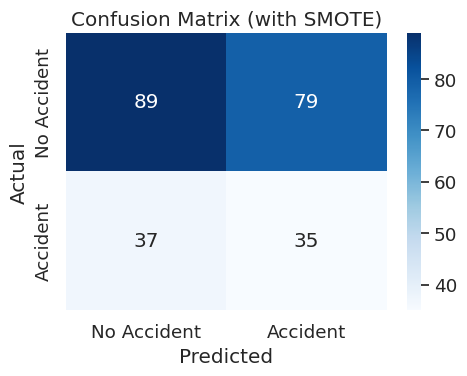

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# 8) Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# 9) Retrain Logistic Regression on the SMOTE’d data
lr_sm = LogisticRegression(class_weight='balanced', random_state=42)
lr_sm.fit(X_train_res, y_train_res)

# 10) Predict on the untouched test set
y_pred_sm = lr_sm.predict(X_test_scaled)

# 11) Accuracy
acc_sm = accuracy_score(y_test, y_pred_sm)
print(f"Accuracy with SMOTE: {acc_sm:.4f}")

# 12) Detailed classification report
print("\nClassification Report with SMOTE:")
print(classification_report(y_test, y_pred_sm, digits=4))

# 13) Confusion matrix heatmap
cm_sm = confusion_matrix(y_test, y_pred_sm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_sm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Accident','Accident'],
            yticklabels=['No Accident','Accident'])
plt.title("Confusion Matrix (with SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



In [22]:
print(X_train.shape)  # Should match the expected feature count
print(X_test.shape)   # Should match the expected feature count

(558, 6)
(240, 6)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best ROC‑AUC on resampled train: 0.7126
Best Logistic Regression Params: {'C': 1, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}
GridSearch training time: 0.1s
Total parameter combinations tested: 32

Training accuracy with best params: 0.5502

Test Accuracy: 0.5167

Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0       0.71      0.52      0.60       168
         1.0       0.31      0.50      0.38        72

    accuracy                           0.52       240
   macro avg       0.51      0.51      0.49       240
weighted avg       0.59      0.52      0.54       240



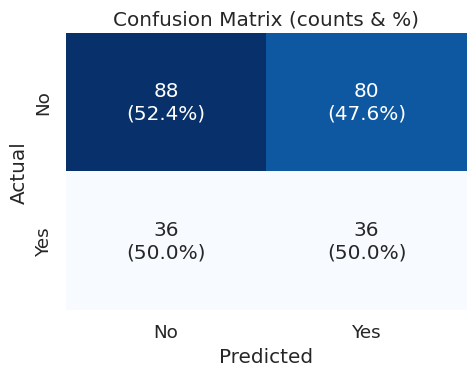


Test ROC‑AUC: 0.5396


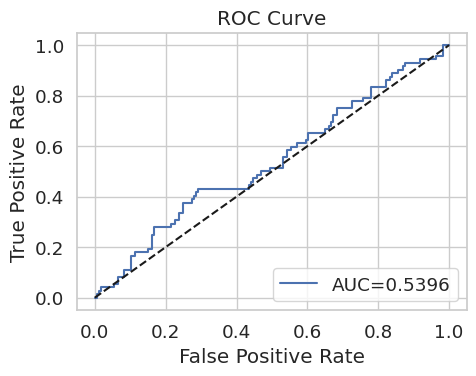

In [23]:
#  Model Evaluation with logistic Regression
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.combine import SMOTEENN
import seaborn as sns
import matplotlib.pyplot as plt


# 1) Balance training data with SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_res, y_res = smote_enn.fit_resample(X_train_scaled, y_train)

# 2) Set up hyperparameter grid for LogisticRegression
param_grid = {
    'C': [0.01, 0.1, 1, 10],        # inverse regularization strength
    'penalty': ['l1', 'l2'],        # regularization type
    'solver': ['liblinear', 'saga'],# solvers that support l1/l2
    'max_iter': [200, 500]          # ensure convergence
}

# 3) Initialize LogisticRegression with balanced class weights
lr = LogisticRegression(class_weight='balanced', random_state=42)

# 4) Use StratifiedKFold for consistent class splits
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 5) GridSearchCV optimizing ROC‑AUC
grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# 6) Run grid search on the SMOTEENN‐resampled training set
start = time.time()
grid.fit(X_res, y_res)
end = time.time()

# 7) Show best results
print(f"Best ROC‑AUC on resampled train: {grid.best_score_:.4f}")
print("Best Logistic Regression Params:", grid.best_params_)
print("GridSearch training time: {:.1f}s".format(end - start))
print("Total parameter combinations tested:", len(grid.cv_results_['params']))

# 8) Retrain best model on the ORIGINAL scaled X_train_scaled
best_lr = grid.best_estimator_
best_lr.fit(X_train_scaled, y_train)
train_score = best_lr.score(X_train_scaled, y_train)
print(f"\nTraining accuracy with best params: {train_score:.4f}")

# 9) Final evaluation on X_test_scaled
y_pred = best_lr.predict(X_test_scaled)
y_proba = best_lr.predict_proba(X_test_scaled)[:,1]

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}")

# Classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix with row‑percentages
cm = confusion_matrix(y_test, y_pred)
cm_pct = cm.astype('float') / cm.sum(axis=1)[:,None] * 100
annot = np.array([[f"{n}\n({p:.1f}%)" 
                   for n,p in zip(row_counts, row_pcts)]
                  for row_counts,row_pcts in zip(cm, cm_pct)])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
            xticklabels=['No','Yes'], yticklabels=['No','Yes'], cbar=False)
plt.title("Confusion Matrix (counts & %)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC‑AUC and curve
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nTest ROC‑AUC: {roc_auc:.4f}")
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Test Accuracy: 0.9450
Test F1-Score: 0.9076
Test ROC-AUC: 0.9721

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       140
           1       0.92      0.90      0.91        60

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.94      0.94       200



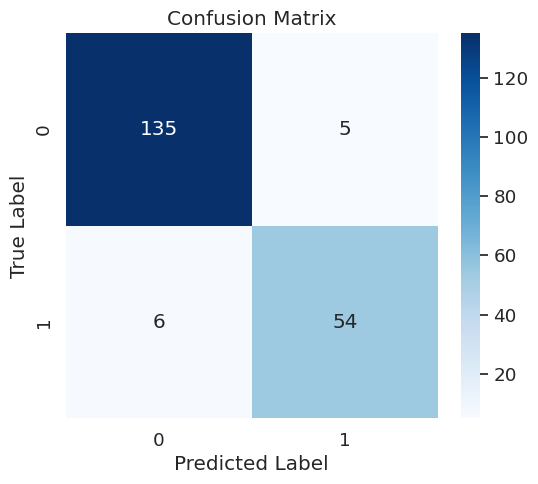

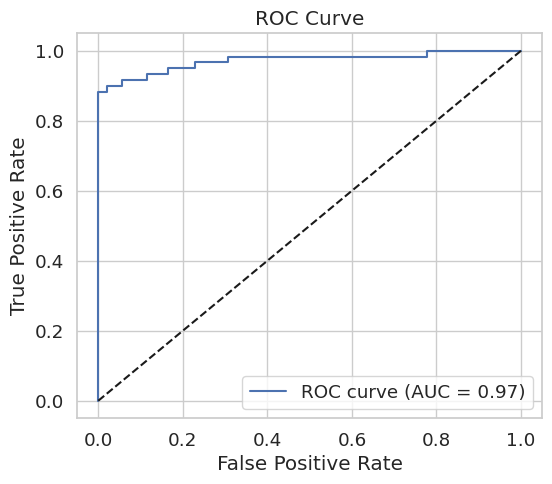

In [24]:
# FINAL MODEL EVALUATION WITH RANDOM FOREST
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=2,
    n_redundant=10,
    n_classes=2,
    weights=[0.7, 0.3],
    flip_y=0,
    random_state=42
)

# Handle missing values if any
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize Random Forest classifier with balanced class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Set up cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Retrieve the best estimator
best_rf = grid_search.best_estimator_

# Predict on the test set
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("Best Hyperparameters:", grid_search.best_params_)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Training Accuracy: 0.9775
Training F1-Score: 0.9619
Training ROC-AUC: 0.9990
Test Accuracy: 0.9450
Test F1-Score: 0.9076
Test ROC-AUC: 0.9721


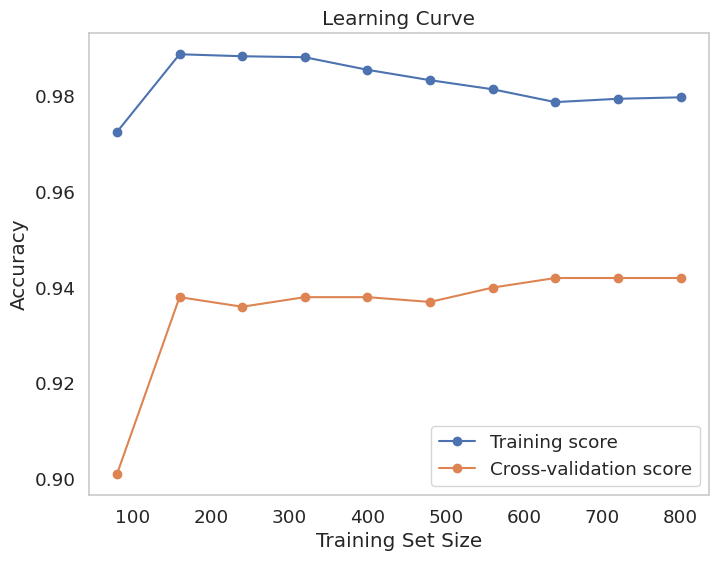

In [25]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Predict on training data
y_train_pred = best_rf.predict(X_train)
y_train_proba = best_rf.predict_proba(X_train)[:, 1]

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_proba)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training F1-Score: {train_f1:.4f}")
print(f"Training ROC-AUC: {train_roc_auc:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_scaled, y, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()
